In [37]:
import modal
import polars as pl
import requests
import zipfile
import io
import seaborn as sns
from lib.viz import count_plot
from markdownify import markdownify as md
from matplotlib import pyplot as plt
from collections import Counter  

In [38]:
labeled_path = "../data/labeled/19_06/legacy.json"
df = pl.read_json(labeled_path)
df.columns

['id_hash',
 'label',
 'title',
 'url',
 'more_info',
 'legal_basis',
 'description',
 'funding_type',
 'funding_location',
 'funding_area',
 'eligible_applicants']

In [39]:
labels = df["label"]
label_counts = Counter(labels)
label_counts_perc = {k: round((v / len(labels)) * 100, 2) for k, v in label_counts.items().__reversed__()}
print(f"Label Distribution: {label_counts}")
print(f"Label Distribution in %: {label_counts_perc}")

Label Distribution: Counter({0: 223, 1: 83})
Label Distribution in %: {0: 72.88, 1: 27.12}


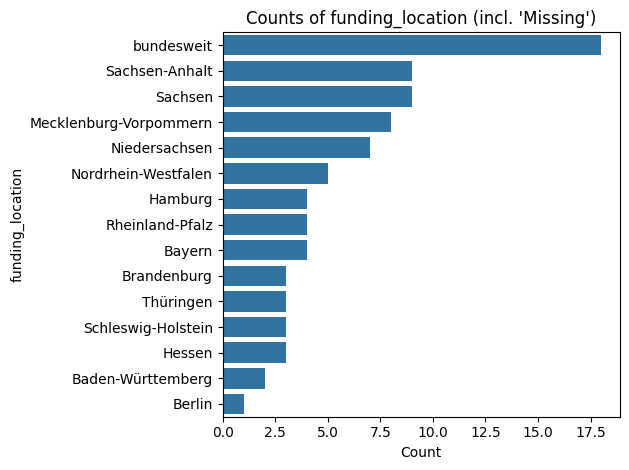

In [40]:
positives = df.filter(pl.col("label") == 1)
count_plot(positives, "funding_location")

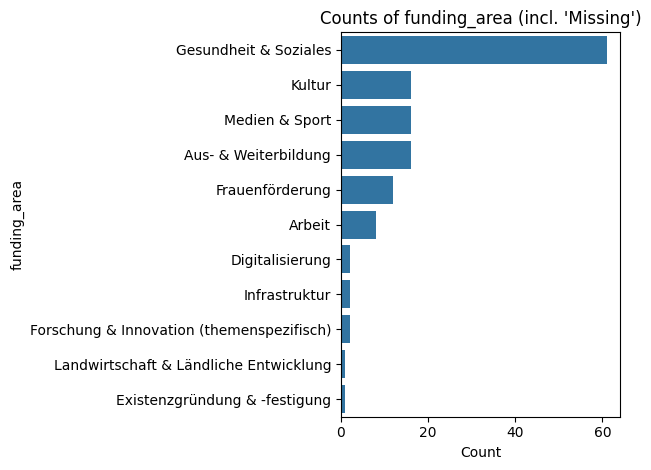

In [41]:
count_plot(positives, "funding_area")

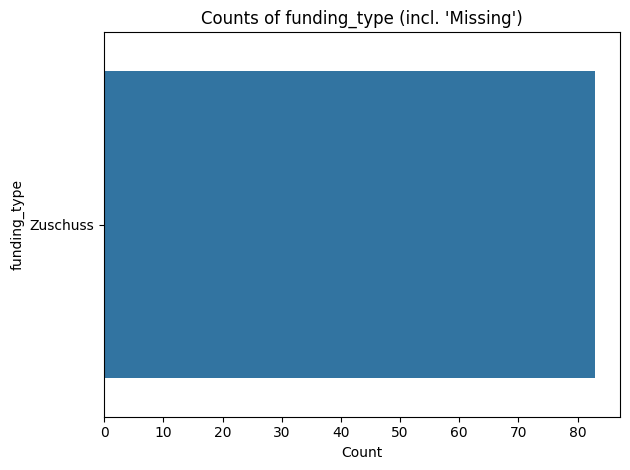

In [42]:
count_plot(positives, "funding_type")

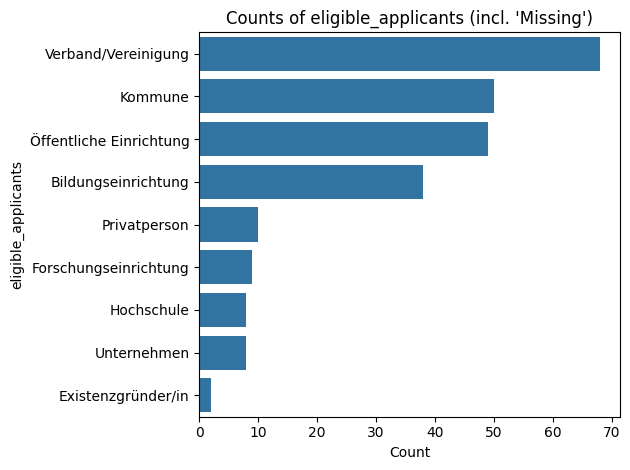

In [43]:
count_plot(positives, "eligible_applicants")

In [44]:
data_url = "https://foerderdatenbankdump.fra1.cdn.digitaloceanspaces.com/data/parquet_data.zip"

response = requests.get(data_url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    file_name = z.namelist()[0]
    with z.open(file_name) as f:
        df_all = pl.read_parquet(f)

There are five main types of funding program description formatting types:

In [61]:
patterns = {
    'Volltext': pl.col("description").str.contains("Volltext") & pl.col("description").str.contains("Kurztext"),
    'Kurztext_only': pl.col("description").str.contains("Kurztext") & ~pl.col("description").str.contains("Volltext"),
    'Volltext_only': pl.col("description").str.contains("Volltext") & ~pl.col("description").str.contains("Kurztext"),
    'Ziel': pl.col("description").str.contains("Ziel und Gegenstand"),
    'description_rechtgrundlage': pl.col("description").str.contains("Rechtsgrundlage")
}

patterns["unknown_description_pattern"] = ~(patterns["Volltext"] | patterns["Kurztext_only"] | patterns["Volltext_only"] | patterns["Ziel"] | patterns["description_rechtgrundlage"])

for name, condition in patterns.items():
    lbl_count = len(df.filter(condition))
    all_count = len(df_all.filter(condition))

    print(f"{name} pattern for labeled: {lbl_count}/{len(df)}; Percentage: {lbl_count / len(df):.4f}")
    print(f"{name} pattern for all: {all_count}/{len(df_all)}; Percentage: {all_count / len(df_all):.4f}\n")


Volltext pattern for labeled: 294/306; Percentage: 0.9608
Volltext pattern for all: 2119/2459; Percentage: 0.8617

Kurztext_only pattern for labeled: 0/306; Percentage: 0.0000
Kurztext_only pattern for all: 6/2459; Percentage: 0.0024

Volltext_only pattern for labeled: 0/306; Percentage: 0.0000
Volltext_only pattern for all: 5/2459; Percentage: 0.0020

Ziel pattern for labeled: 3/306; Percentage: 0.0098
Ziel pattern for all: 108/2459; Percentage: 0.0439

description_rechtgrundlage pattern for labeled: 8/306; Percentage: 0.0261
description_rechtgrundlage pattern for all: 219/2459; Percentage: 0.0891

unknown_description_pattern pattern for labeled: 1/306; Percentage: 0.0033
unknown_description_pattern pattern for all: 8/2459; Percentage: 0.0033

